# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. We'll build a convolutional autoencoder to compress the MNIST dataset. 

>The encoder portion will be made of convolutional and pooling layers and the decoder will be made of **transpose convolutional layers** that learn to "upsample" a compressed representation.

<img src='notebook_ims/autoencoder_1.png' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!

<img src='notebook_ims/denoising.png' width=60%/>

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available! Training on GPU...')
else:
    print('CUDA is not available. Training on CPU...')

CUDA is available! Training on GPU...


### Data

In [4]:
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor()])

# Download the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download = True, train = True, transform = transform)

# Download the test data 
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download = True, train = False, transform = transform)

# trainloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 20)

# testloader
testloader = torch.utils.data.DataLoader(testset, batch_size = 20)

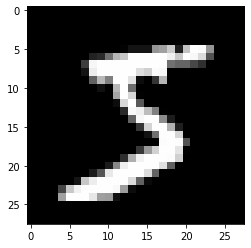

In [5]:
images, labels = next(iter(trainloader))
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')
plt.show()

---
## Convolutional  Autoencoder

#### Encoder
The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. 

#### Decoder

The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide, reconstructed image. For example, the representation could be a 7x7x4 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the compressed representation. A schematic of the network is shown below.

<img src='notebook_ims/conv_enc_1.png' width=640px>

Here our final encoder layer has size 7x7x4 = 196. The original images have size 28x28 = 784, so the encoded vector is 25% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, in fact, you're encouraged to add additional layers to make this representation even smaller! Remember our goal here is to find a small representation of the input data.

### Transpose Convolutions, Decoder

This decoder uses **transposed convolutional** layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. PyTorch provides us with an easy way to create the layers, [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d). 

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. 

> We'll show this approach in another notebook, so you can experiment with it and see the difference.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # encoder layers
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) # 28x28x1 * (3x3x1)x16 = 28x28x16 -->maxpooling (2x2) --> 14x14x16
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1) # 14x14x16 * (3x3x16)x4 = 14x14x4 -->maxpooling (2x2) --> 7x7x4
        
        # pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2) # 7x7x4 *T(2x2)x16 --> # 14x14x16
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2) # 14x14x16 *T(2x2)x1 --> # 28x28x1      
            
            
    def forward(self, x):
        
        # encoder
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # decoder
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
        
        return x  

In [7]:
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [8]:
if train_on_gpu:
    model.cuda()

## Training 

In [9]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 20

for epoch in range(epochs):
    train_loss = 0
    for images, _ in trainloader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad() 
        output = model(images)
        loss = criterion(output, images)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()
        
    print('Epoch: {} Train loss: {}' .format(epoch + 1, train_loss/len(trainloader)))

C:\Users\Hanna\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 Train loss: 0.03022324399401744
Epoch: 2 Train loss: 0.013433540491697689
Epoch: 3 Train loss: 0.012247912044016023
Epoch: 4 Train loss: 0.011560938516942162
Epoch: 5 Train loss: 0.011050446555949748
Epoch: 6 Train loss: 0.010746483620877068
Epoch: 7 Train loss: 0.010553044760910173
Epoch: 8 Train loss: 0.010332924630027265
Epoch: 9 Train loss: 0.010165378812234848
Epoch: 10 Train loss: 0.010048974974391361
Epoch: 11 Train loss: 0.0099668706106022
Epoch: 12 Train loss: 0.00990130914732193
Epoch: 13 Train loss: 0.009843724955028544
Epoch: 14 Train loss: 0.009790804345626384
Epoch: 15 Train loss: 0.009738229282510778
Epoch: 16 Train loss: 0.00967443005181849
Epoch: 17 Train loss: 0.009620275953939805
Epoch: 18 Train loss: 0.009576028342824429
Epoch: 19 Train loss: 0.009528749281540513
Epoch: 20 Train loss: 0.00948684828930224


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

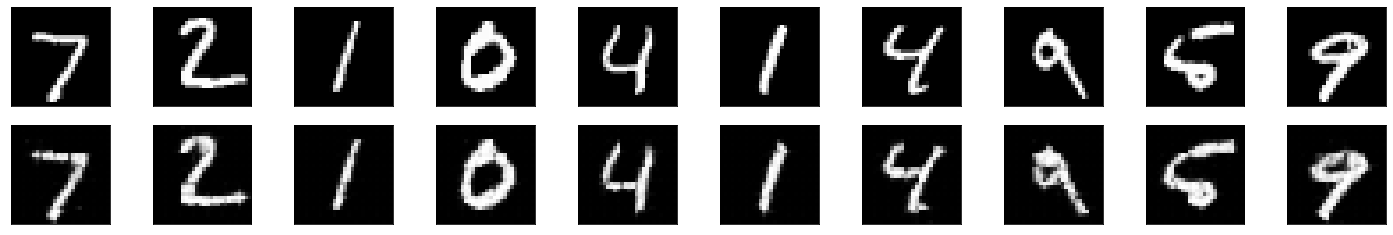

In [15]:
images, labels = next(iter(testloader))
if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()

output = model(images)
output = output.view(images.shape[0], 1, 28, 28)

# gpu to cpu
images = images.cpu()
output = output.cpu()

# numpy for plot

images = images.numpy()
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
